# Salinity figures for PanAntarctic comparison

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cf_xarray
import cmocean as cm

## Mapping

In [2]:
# Import the data (names generalised to use for both comparisons)

data_1a = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/bottom_salinity_map_Pan01.nc', chunks = 'auto')
data_2a = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/bottom_salinity_map_Pan005.nc', chunks = 'auto')

data_1b = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_salinity_map_Pan01.nc', chunks = 'auto')
data_2b = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_salinity_map_Pan005.nc', chunks = 'auto')

In [3]:
# Land and contour data
shelf_contour_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
shelf_contour_2 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)

depth_2 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)

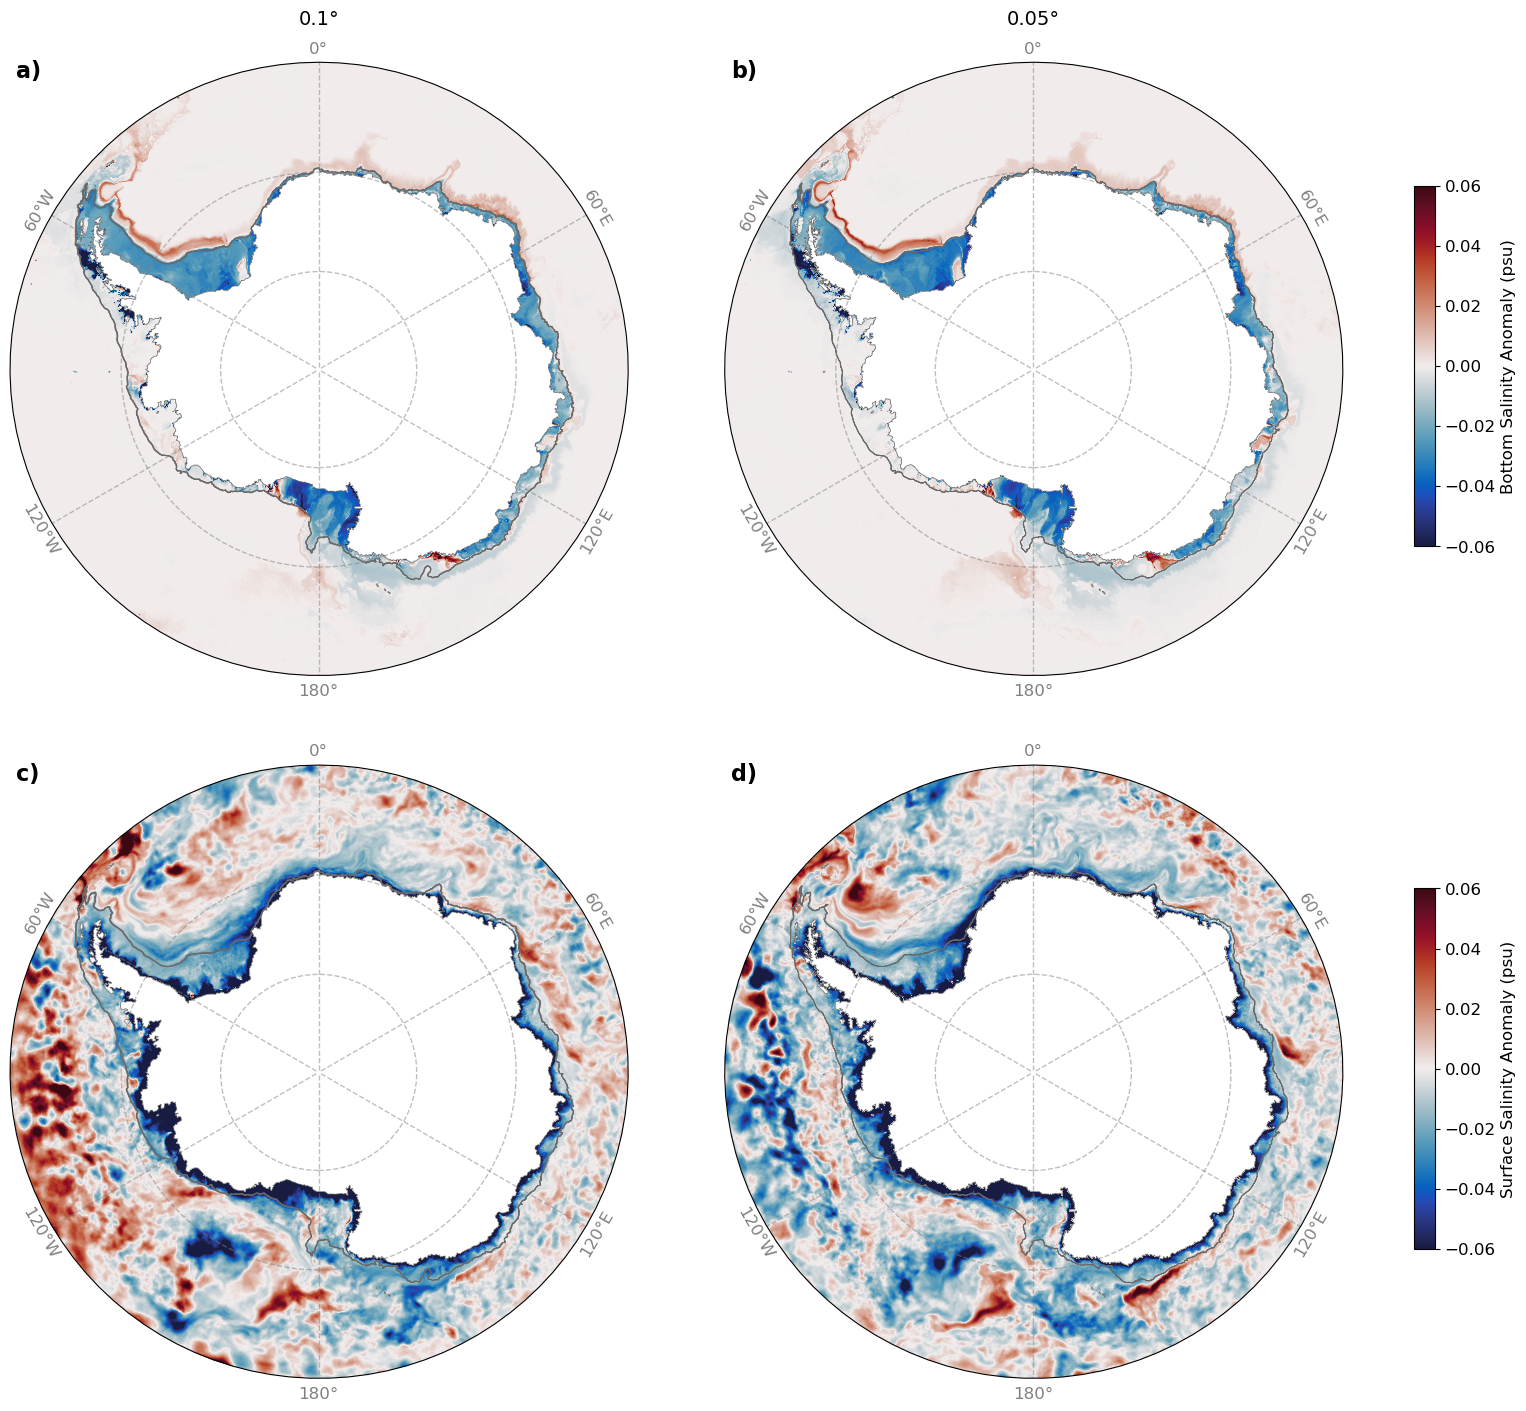

In [4]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 rows and 2 columns
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    subplot_kw={"projection": projection},
    figsize=(16, 14),
    constrained_layout=True
)
axes = axes.flatten()  # easier indexing

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
datasets = [data_1a, data_2a, data_1b, data_2b]
land_masks = [land_1, land_2, land_1, land_2]
land_contours = [land_mask_1, land_mask_2, land_mask_1, land_mask_2]
shelf_masks = [shelf_contour_1, shelf_contour_2, shelf_contour_1, shelf_contour_2]
titles = ["0.1°", "0.05°", " ", " "]  # update as needed

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -58, -58, -58]

# --- Loop over subplots ---
ims = []  # store handles for colorbars
for i, (ax, data, land_m, land_contour, shelf_m, title) in enumerate(zip(
        axes, datasets, land_masks, land_contours, shelf_masks, titles)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = data.plot(
        x="xh", y="yh",
        transform=ccrs.PlateCarree(),
        vmin=-0.06, vmax=0.06,
        extend="both",
        cmap=cm.cm.balance, #plt.get_cmap('RdBu').reversed(),
        add_colorbar=False,
        ax=ax,
    )
    ims.append(im)

    # Set title
    ax.set_title(title, fontsize=14, pad=25)

    # Add subplot label (a), (b), etc.
    ax.text(0.01, 1, f'{chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# --- Colorbars for each row ---
# Top row → bottom temp anomaly
cbar1 = fig.colorbar(
    ims[0], ax=axes[0:2], orientation="vertical",
    fraction=0.015, aspect=17, shrink=0.8, pad=0.05
)
cbar1.set_label("Bottom Salinity Anomaly (psu)", fontsize=12)
cbar1.ax.tick_params(labelsize=12)

# Bottom row → mid-depth temp anomaly
cbar2 = fig.colorbar(
    ims[2], ax=axes[2:4], orientation="vertical",
    fraction=0.015, aspect=17, shrink=0.8, pad=0.05
)
cbar2.set_label("Surface Salinity Anomaly (psu)", fontsize=12)
cbar2.ax.tick_params(labelsize=12)

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_salinity_maps_2x2_v2.png",
            dpi=300, bbox_inches='tight')


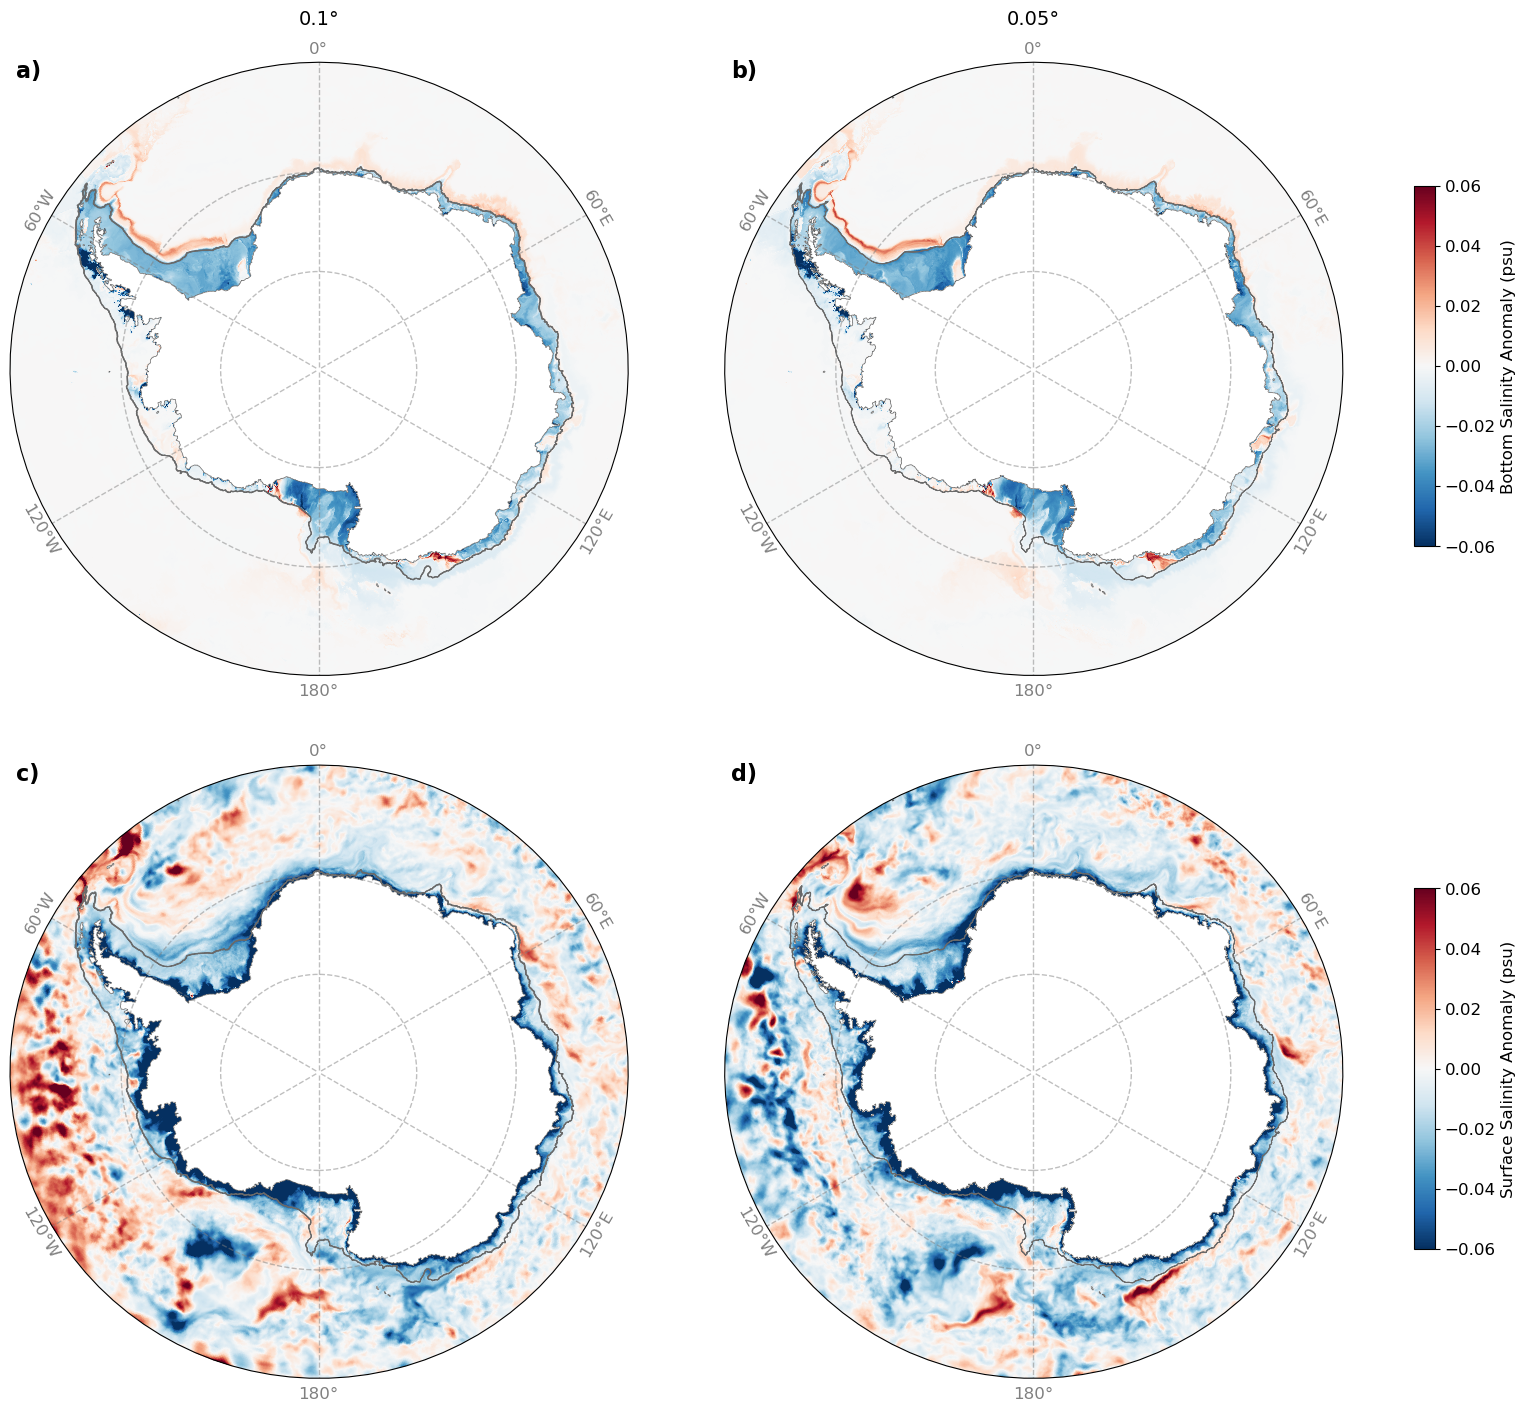

In [8]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 rows and 2 columns
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    subplot_kw={"projection": projection},
    figsize=(16, 14),
    constrained_layout=True
)
axes = axes.flatten()  # easier indexing

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
datasets = [data_1a, data_2a, data_1b, data_2b]
land_masks = [land_1, land_2, land_1, land_2]
land_contours = [land_mask_1, land_mask_2, land_mask_1, land_mask_2]
shelf_masks = [shelf_contour_1, shelf_contour_2, shelf_contour_1, shelf_contour_2]
titles = ["0.1°", "0.05°", " ", " "]  # update as needed

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -58, -58, -58]

# --- Loop over subplots ---
ims = []  # store handles for colorbars
for i, (ax, data, land_m, land_contour, shelf_m, title) in enumerate(zip(
        axes, datasets, land_masks, land_contours, shelf_masks, titles)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = data.plot(
        x="xh", y="yh",
        transform=ccrs.PlateCarree(),
        vmin=-0.06, vmax=0.06,
        extend="both",
        cmap=plt.get_cmap('RdBu').reversed(),
        add_colorbar=False,
        ax=ax,
    )
    ims.append(im)

    # Set title
    ax.set_title(title, fontsize=14, pad=25)

    # Add subplot label (a), (b), etc.
    ax.text(0.01, 1, f'{chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# --- Colorbars for each row ---
# Top row → bottom temp anomaly
cbar1 = fig.colorbar(
    ims[0], ax=axes[0:2], orientation="vertical",
    fraction=0.015, aspect=17, shrink=0.8, pad=0.05
)
cbar1.set_label("Bottom Salinity Anomaly (psu)", fontsize=12)
cbar1.ax.tick_params(labelsize=12)

# Bottom row → mid-depth temp anomaly
cbar2 = fig.colorbar(
    ims[2], ax=axes[2:4], orientation="vertical",
    fraction=0.015, aspect=17, shrink=0.8, pad=0.05
)
cbar2.set_label("Surface Salinity Anomaly (psu)", fontsize=12)
cbar2.ax.tick_params(labelsize=12)

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_salinity_maps_2x2_v1.png",
            dpi=300, bbox_inches='tight')


### Time series

In [17]:
import pandas as pd

In [18]:
# Bottom salinity
data_1a_time = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_pan01.nc', chunks = 'auto')
data_2a_time = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_pan005.nc', chunks = 'auto')

# Surface salinity
data_1b_time = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_pan01.nc', chunks = 'auto')
data_2b_time = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_pan005.nc', chunks = 'auto')

In [19]:
data_1a_time_new = data_1a_time.to_series()
data_2a_time_new = data_2a_time.to_series()

data_1b_time_new = data_1b_time.to_series()
data_2b_time_new = data_2b_time.to_series()

In [20]:
# Slice 1910–1919 and 2001–2010
data_1a_time_new = data_1a_time_new['2001-01-01':'2010-10-16']
data_2a_time_new = data_2a_time_new['2001-01-01':'2010-10-16']

data_1b_time_new = data_1b_time_new['2001-01-01':'2010-10-16']
data_2b_time_new = data_2b_time_new['2001-01-01':'2010-10-16']

# Reset index to normalized months
data_1a_time_new.index = range(1, len(data_1a_time_new)+1)
data_2a_time_new.index = range(1, len(data_2a_time_new)+1)

data_1b_time_new.index = range(1, len(data_1b_time_new)+1)
data_2b_time_new.index = range(1, len(data_2b_time_new)+1)

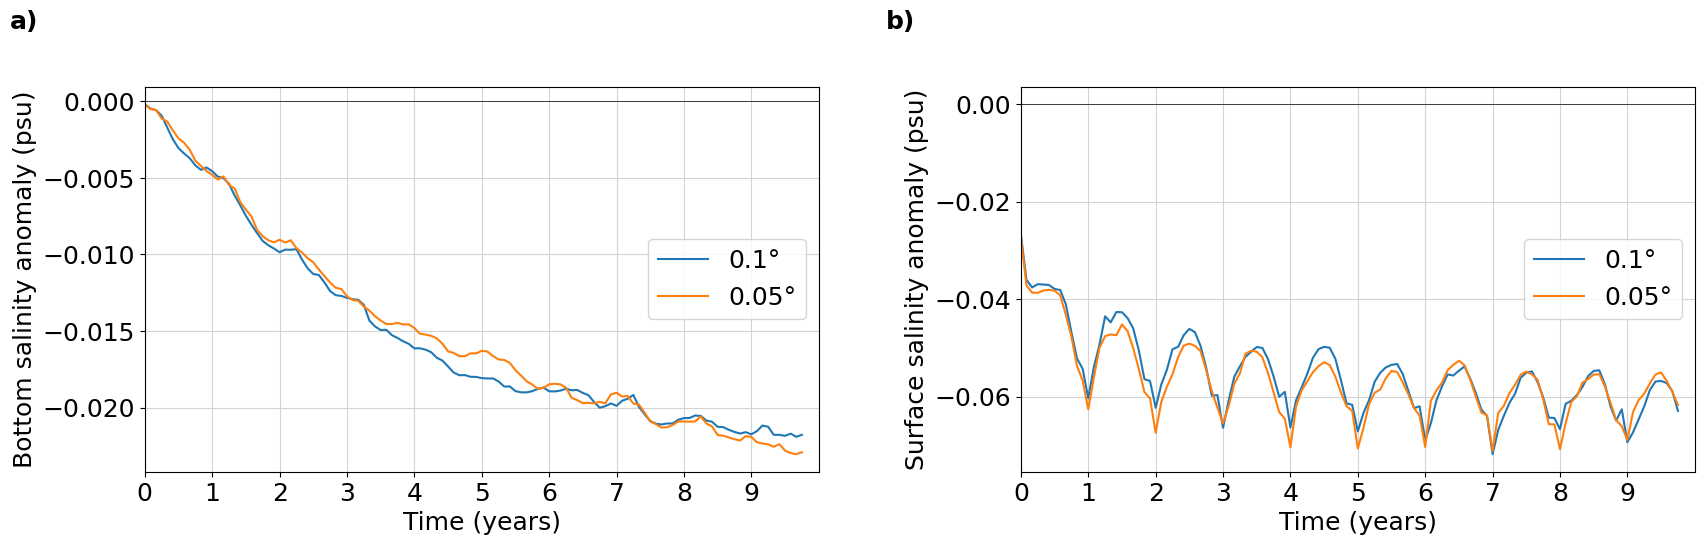

In [22]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18

# Two panels: bottom and surface
datasets = [
    (data_1a_time_new, data_2a_time_new, "Bottom"),
    (data_1b_time_new, data_2b_time_new, "Surface"),
]

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 5),
    constrained_layout=False
)

for i, (data1, data2, title) in enumerate(datasets):
    ax = axes[i]

    # Plot both resolutions
    ax.plot(data1.index, data1.values, label="0.1°")
    ax.plot(data2.index, data2.values, label="0.05°")

    # X ticks as years 1–10
    ax.set_xticks(range(1, 121, 12))
    ax.set_xticklabels([str(j) for j in range(0, 10)])

    # Horizontal zero line
    ax.axhline(0, color="black", linewidth=0.5)

    # Y-axis labels depend on subplot
    if i == 0:
        ax.set_ylabel("Bottom salinity anomaly (psu)")
    else:
        ax.set_ylabel("Surface salinity anomaly (psu)")

    # X-axis label
    ax.set_xlabel("Time (years)")
    ax.set_xlim(1,121)

    # Subplot labels (a), (b), etc.
    ax.text(-.2, 1.2, f"{chr(97+i)})", transform=ax.transAxes,
            fontsize=18, fontweight="bold", va="top", ha="left", color="black")

    # Legend + grid
    ax.legend(loc='center right')
    ax.grid(True, color="lightgrey")

# Add space between subplots
plt.subplots_adjust(wspace=0.3)  # increase horizontal spacing (default ~0.2)

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_salinity_timeseries.png",
            dpi=300, bbox_inches='tight')

#### Regional time series

In [10]:
# Importing data
pan01_botsalt_1 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Adelie_pan01.nc', chunks='auto') 
pan005_botsalt_1 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Adelie_pan005.nc', chunks='auto')

pan01_botsalt_2 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Ross_pan01.nc', chunks='auto') 
pan005_botsalt_2 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Ross_pan005.nc', chunks='auto')

pan01_botsalt_3 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Am_pan01.nc', chunks='auto') 
pan005_botsalt_3 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Am_pan005.nc', chunks='auto')

pan01_botsalt_4 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Be_pan01.nc', chunks='auto') 
pan005_botsalt_4 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Be_pan005.nc', chunks='auto')

pan01_botsalt_5 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Weddell_pan01.nc', chunks='auto') 
pan005_botsalt_5 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Weddell_pan005.nc', chunks='auto')

pan01_botsalt_6 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Prydz_pan01.nc', chunks='auto') 
pan005_botsalt_6 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Prydz_pan005.nc', chunks='auto')

In [11]:
pan01_botsalt_1_new = pan01_botsalt_1.to_series()
pan005_botsalt_1_new = pan005_botsalt_1.to_series()

pan01_botsalt_2_new = pan01_botsalt_2.to_series()
pan005_botsalt_2_new = pan005_botsalt_2.to_series()

pan01_botsalt_3_new = pan01_botsalt_3.to_series()
pan005_botsalt_3_new = pan005_botsalt_3.to_series()

pan01_botsalt_4_new = pan01_botsalt_4.to_series()
pan005_botsalt_4_new = pan005_botsalt_4.to_series()

pan01_botsalt_5_new = pan01_botsalt_5.to_series()
pan005_botsalt_5_new = pan005_botsalt_5.to_series()

pan01_botsalt_6_new = pan01_botsalt_6.to_series()
pan005_botsalt_6_new = pan005_botsalt_6.to_series()

In [12]:
# Reset index to normalized months
pan01_botsalt_1_new.index = range(0, len(pan01_botsalt_1_new))
pan005_botsalt_1_new.index = range(0, len(pan005_botsalt_1_new))

pan01_botsalt_2_new.index = range(0, len(pan01_botsalt_2_new))
pan005_botsalt_2_new.index = range(0, len(pan005_botsalt_2_new))

pan01_botsalt_3_new.index = range(0, len(pan01_botsalt_3_new))
pan005_botsalt_3_new.index = range(0, len(pan005_botsalt_3_new))

pan01_botsalt_4_new.index = range(0, len(pan01_botsalt_4_new))
pan005_botsalt_4_new.index = range(0, len(pan005_botsalt_4_new))

pan01_botsalt_5_new.index = range(0, len(pan01_botsalt_5_new))
pan005_botsalt_5_new.index = range(0, len(pan005_botsalt_5_new))

pan01_botsalt_6_new.index = range(0, len(pan01_botsalt_6_new))
pan005_botsalt_6_new.index = range(0, len(pan005_botsalt_6_new))

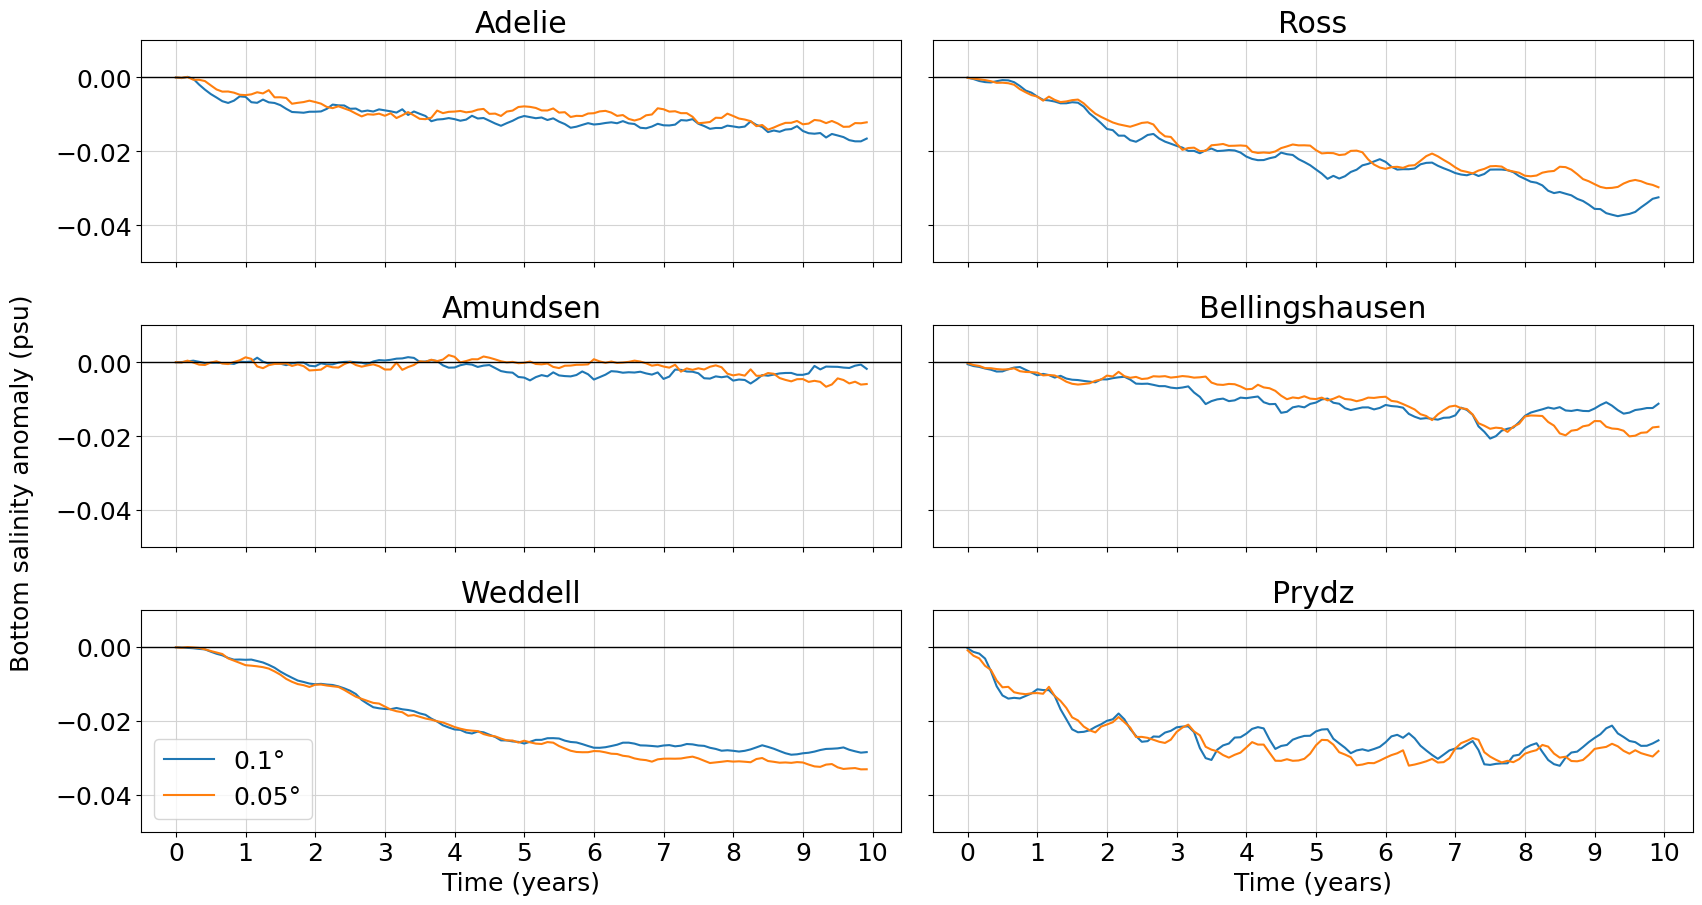

In [75]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    sharex=False, figsize=(18, 10)
)
axes = axes.flatten()

# First subplot: 
pan01_botsalt_1_new.plot(ax=axes[0], label="PanAn 1/10th")
pan005_botsalt_1_new.plot(ax=axes[0], label="PanAn 1/20th")
#axes[0].legend(loc="lower left")
axes[0].set_title("Adelie")

# Second subplot: 
pan01_botsalt_2_new.plot(ax=axes[1], label="PanAn 1/10th")
pan005_botsalt_2_new.plot(ax=axes[1], label="PanAn 1/20th")
#axes[1].legend(loc="lower left")
axes[1].set_title("Ross")

# Third subplot: 
pan01_botsalt_3_new.plot(ax=axes[2], label="PanAn 1/10th")
pan005_botsalt_3_new.plot(ax=axes[2], label="PanAn 1/20th")
#axes[2].legend(loc="lower left")
axes[2].set_title("Amundsen")

# Fourth subplot: 
pan01_botsalt_4_new.plot(ax=axes[3], label="PanAn 1/10th")
pan005_botsalt_4_new.plot(ax=axes[3], label="PanAn 1/20th")
#axes[3].legend(loc="lower left")
axes[3].set_title("Bellingshausen")

# Fifth subplot: 
pan01_botsalt_5_new.plot(ax=axes[4], label="0.1°")
pan005_botsalt_5_new.plot(ax=axes[4], label="0.05°")
axes[4].legend(loc="lower left")
axes[4].set_title("Weddell")

# Sixth subplot: 
pan01_botsalt_6_new.plot(ax=axes[5], label="PanAn 1/10th")
pan005_botsalt_6_new.plot(ax=axes[5], label="PanAn 1/20th")
#axes[5].legend(loc="lower left")
axes[5].set_title("Prydz")

# Apply consistent y-limits, grid, and horizontal line
for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.05, 0.01)
    ax.grid(True, color='lightgrey')

# Remove y-axis ticks from the right column
for ax in axes[1::2]:  # axes[1], axes[3], axes[5]
    ax.set_yticklabels([])

# Add common X and Y labels
#fig.text(0.5, 0.04, "Time (years)", ha='center')
fig.text(0.05, 0.5, "Bottom salinity anomaly (psu)", va='center', rotation='vertical')

# X-ticks: every 12 months, labeled in years
ticks = range(0, 121, 12)
labels = [str(i) for i in range(len(ticks))]
plt.setp(axes, xticks=ticks, xticklabels=labels)

# Only bottom row gets x-axis labels
for ax in axes[:-2]:
    ax.set_xlabel("")
    ax.set_xticklabels([])

for ax in axes[-2:]:
    ax.set_xlabel("Time (years)")

# Layout
plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_salinity_timeseries_regional.png",
            dpi=300, bbox_inches='tight')

#### Bathymetry plot

In [13]:
from pathlib import Path

In [14]:
path_to_ocean_static = Path('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
ocean_static = xr.open_dataset(path_to_ocean_static)

deptho = ocean_static['deptho']
xh = ocean_static['xh']
yh = ocean_static['yh']

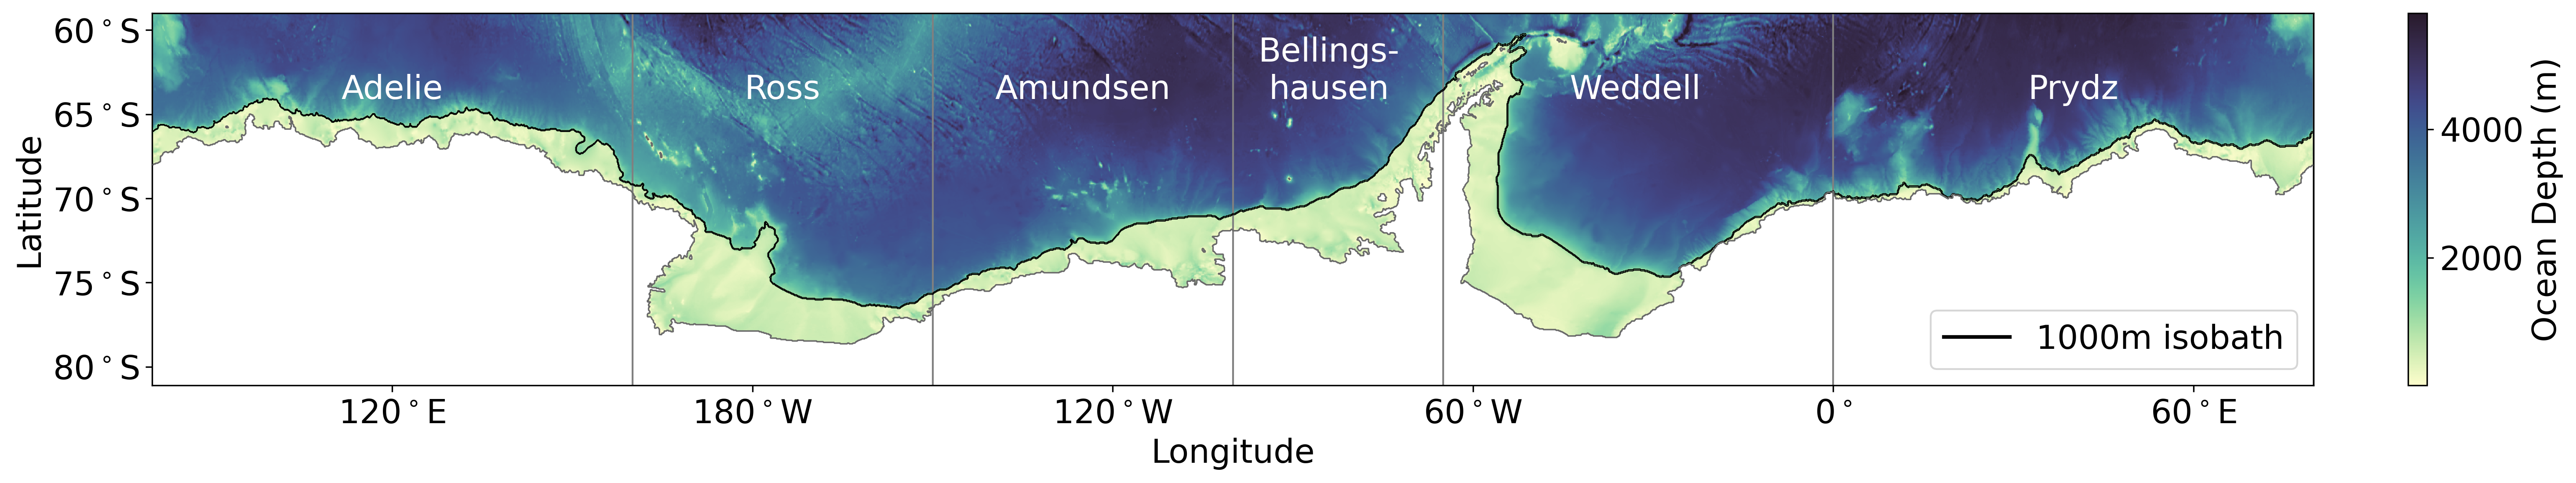

In [97]:
plt.rcParams['font.size'] = 18

# Make a fresh figure for only the i) panel
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)

# Bathymetry map
h_plot = deptho.plot(ax=ax, cmap=cm.cm.deep, add_colorbar=False)

# Proper colorbar, same height as the plot
cbar = fig.colorbar(h_plot, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.set_label("Ocean Depth (m)")

# Contours
ax.contour(shelf_contour_1.cf['X'], shelf_contour_1.cf['Y'], shelf_contour_1,
           levels=[0.5], colors='black', linewidths=0.5, zorder=4)
ax.contour(land_mask_1.cf['X'], land_mask_1.cf['Y'], land_mask_1,
           levels=[0.5], colors='dimgrey', linewidths=0.8, zorder=5)

# Region lines + labels
ax.vlines([-280, -200, -150, -100, -65, 0, 80], -82, -58, color='grey', linewidth=1)
region_labels = ['Adelie', 'Ross', 'Amundsen', 'Bellings-\nhausen', 'Weddell', 'Prydz']
region_lons   = [-240, -175, -125, -84, -33, 40]
for x, name in zip(region_lons, region_labels):
    ax.text(x, -64.5, name, ha='center', va='bottom', color='w')

# Fake legend entry
ax.plot([0, 1], [0, 1], color='k', linewidth=2, label='1000m isobath')
ax.legend(loc='lower right')

# Axes labels, ticks
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim(min(yh.values), -59)
ax.set_xticks([-240, -180, -120, -60, 0, 60])
ax.set_xticklabels(('120$^\circ$E', '180$^\circ$W', '120$^\circ$W',
                    '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax.set_yticks([-80, -75, -70, -65, -60])
ax.set_yticklabels(('80$^\circ$S', '75$^\circ$S', '70$^\circ$S',
                    '65$^\circ$S', '60$^\circ$S'))

fig.tight_layout()
fig.savefig("panel_i.png", dpi=300)
plt.show()


#### Combining the plots

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec

/jobfs/150295861.gadi-pbs/ipykernel_1133038/4225910726.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


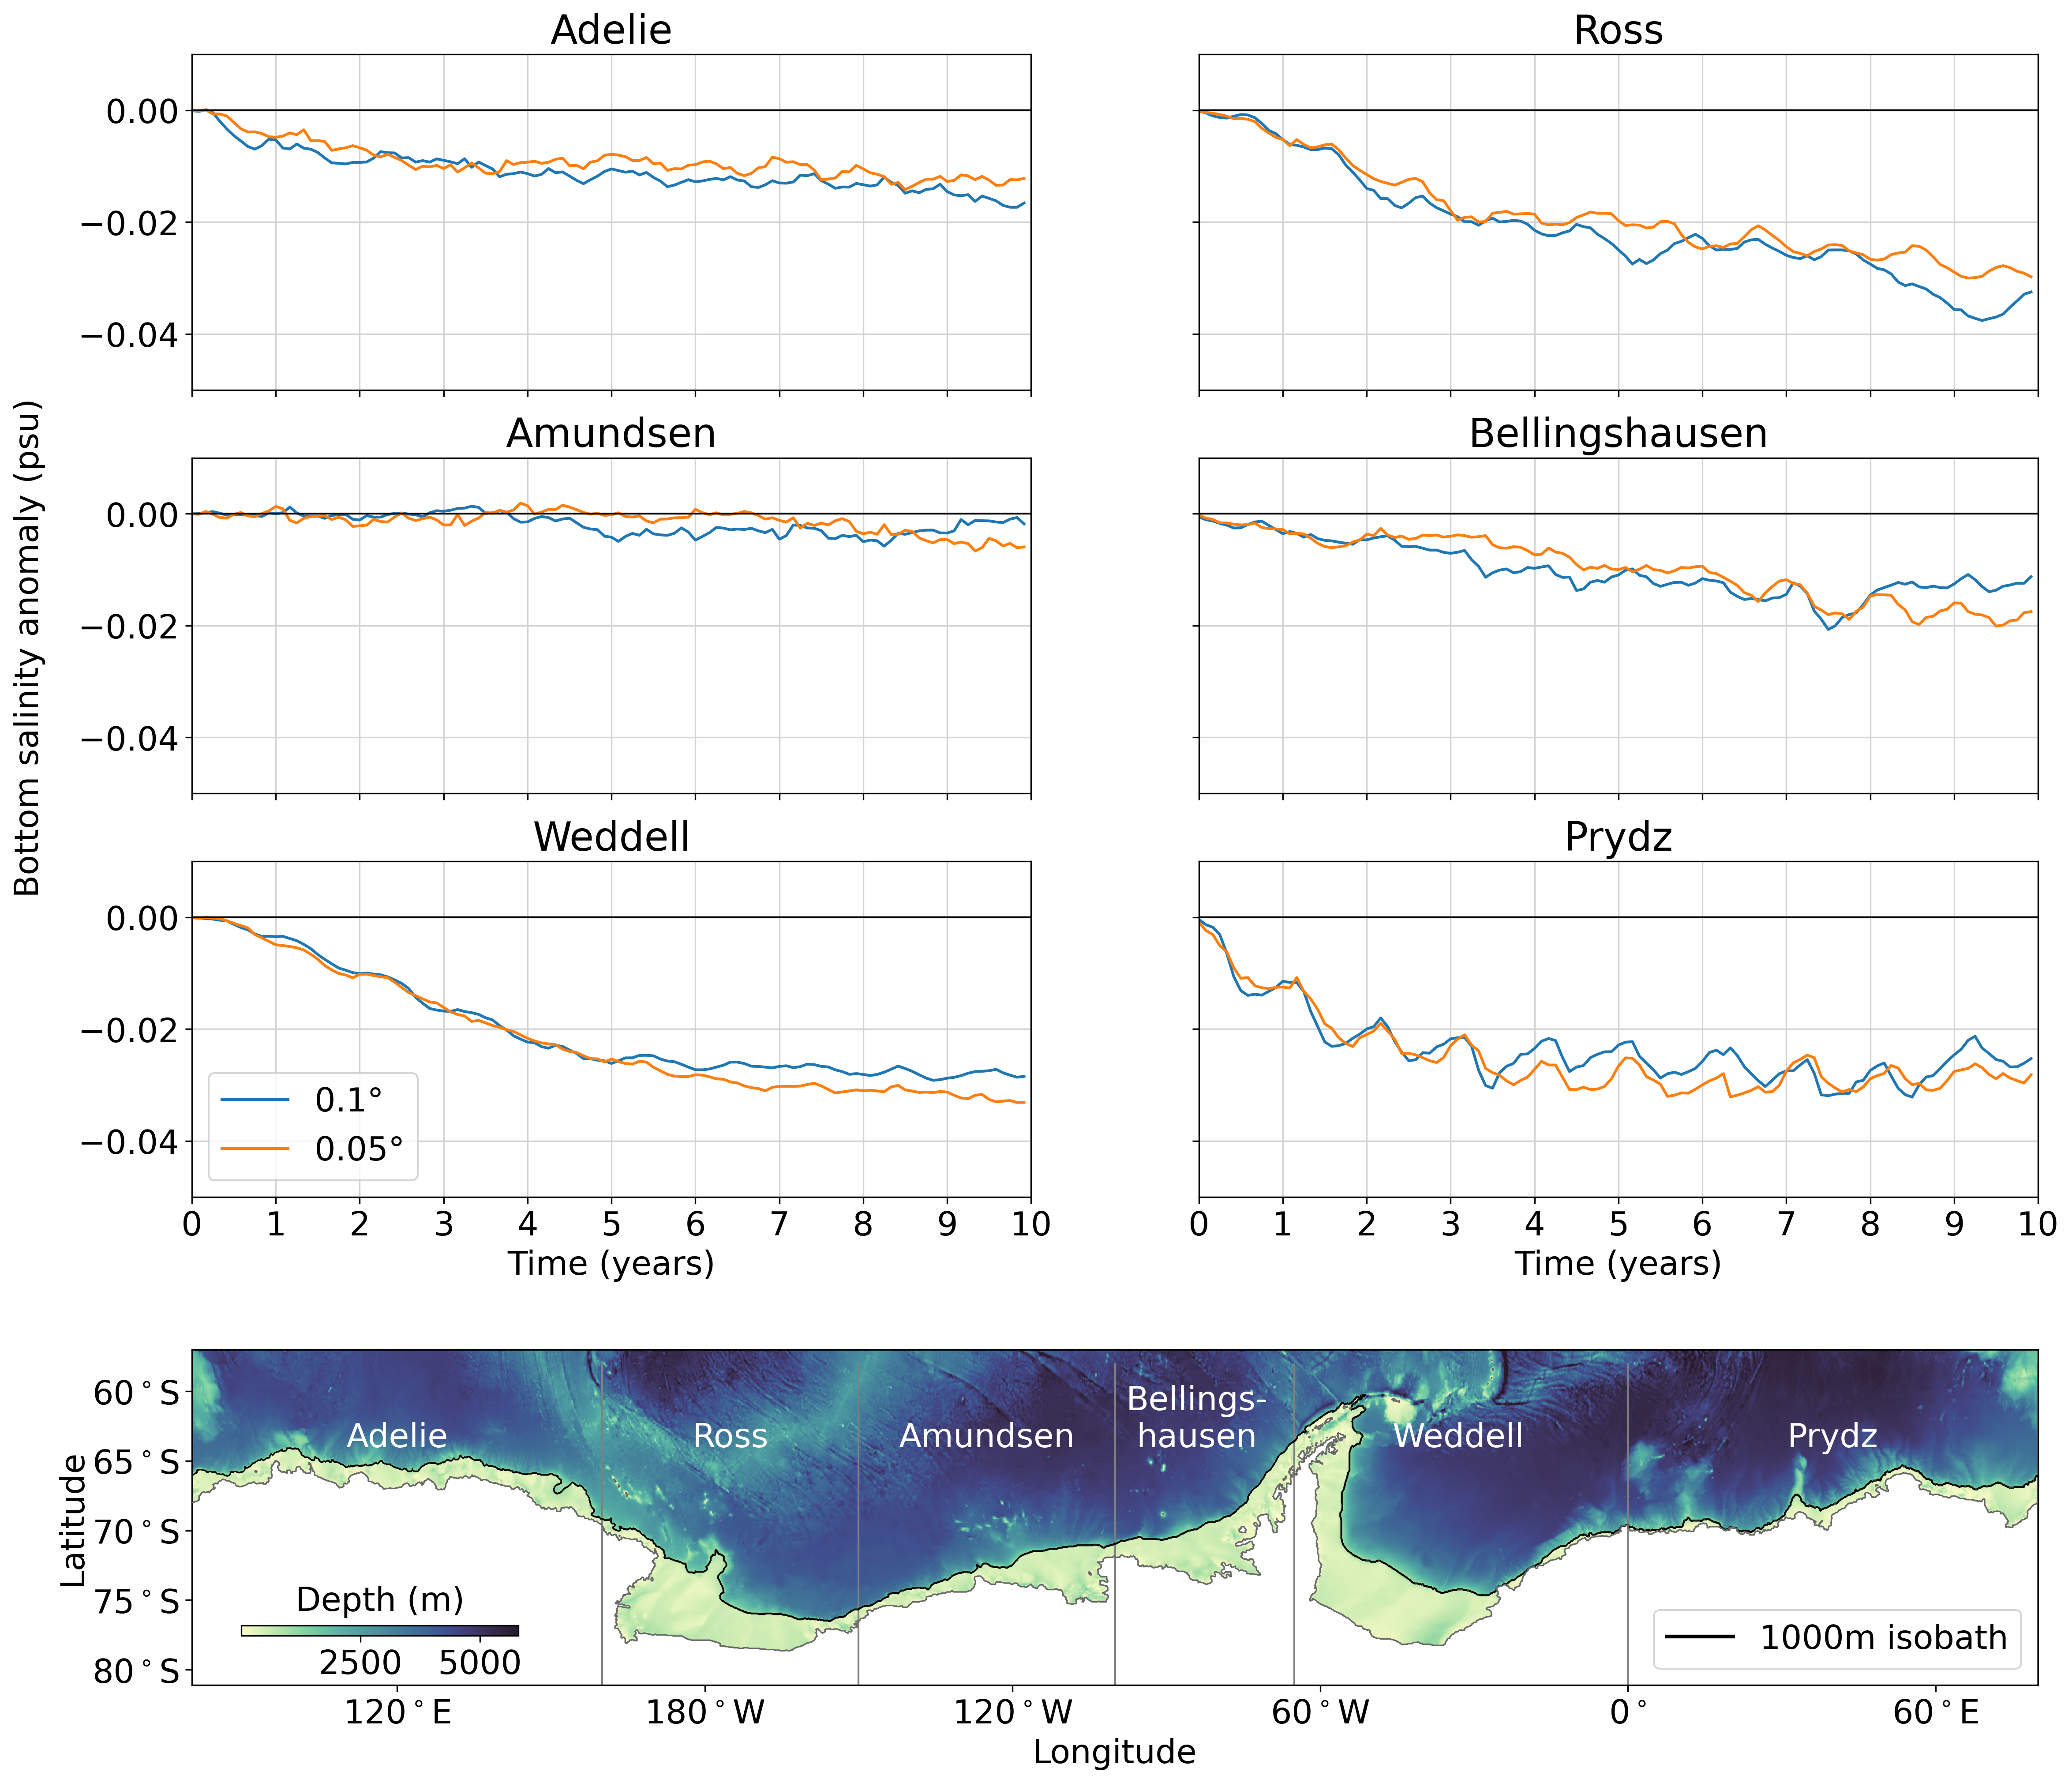

In [24]:
plt.rcParams['font.size'] = 18

# --- Create figure with 5 rows (spacer row before bathy) ---
fig = plt.figure(figsize=(18, 16), dpi=300)
gs = gridspec.GridSpec(
    nrows=5, ncols=2,
    height_ratios=[1, 1, 1, 0.05, 1],  # small spacer row before bathy
    figure=fig,
    hspace=0.25  # small space between top three rows
)

# --- Time series axes (rows 0-2) ---
axes = [fig.add_subplot(gs[i]) for i in range(6)]  # rows 0-2

# First subplot
pan01_botsalt_1_new.plot(ax=axes[0], label="PanAn 1/10th")
pan005_botsalt_1_new.plot(ax=axes[0], label="PanAn 1/20th")
axes[0].set_title("Adelie")

# Second subplot
pan01_botsalt_2_new.plot(ax=axes[1], label="PanAn 1/10th")
pan005_botsalt_2_new.plot(ax=axes[1], label="PanAn 1/20th")
axes[1].set_title("Ross")

# Third subplot
pan01_botsalt_3_new.plot(ax=axes[2], label="PanAn 1/10th")
pan005_botsalt_3_new.plot(ax=axes[2], label="PanAn 1/20th")
axes[2].set_title("Amundsen")

# Fourth subplot
pan01_botsalt_4_new.plot(ax=axes[3], label="PanAn 1/10th")
pan005_botsalt_4_new.plot(ax=axes[3], label="PanAn 1/20th")
axes[3].set_title("Bellingshausen")

# Fifth subplot
pan01_botsalt_5_new.plot(ax=axes[4], label="0.1°")
pan005_botsalt_5_new.plot(ax=axes[4], label="0.05°")
axes[4].legend(loc="lower left")
axes[4].set_title("Weddell")

# Sixth subplot
pan01_botsalt_6_new.plot(ax=axes[5], label="PanAn 1/10th")
pan005_botsalt_6_new.plot(ax=axes[5], label="PanAn 1/20th")
axes[5].set_title("Prydz")

# Apply consistent y-limits, grid, horizontal line
for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.05, 0.01)
    ax.set_xlim(0,10)
    ax.grid(True, color='lightgrey')

# Remove y-axis ticks from right column
for ax in axes[1::2]:
    ax.set_yticklabels([])

# Common Y label
fig.text(0.05, 0.6, "Bottom salinity anomaly (psu)", va='center', rotation='vertical')

# X-ticks
ticks = range(0, 121, 12)
labels = [str(i) for i in range(len(ticks))]
plt.setp(axes, xticks=ticks, xticklabels=labels)

# Only bottom row gets x-axis labels
for ax in axes[:-2]:
    ax.set_xlabel("")
    ax.set_xticklabels([])
for ax in axes[-2:]:
    ax.set_xlabel("Time (years)")

# --- Bathymetry panel (fifth row, after spacer) ---
ax_bathy = fig.add_subplot(gs[4, :])  # spans both columns
h_plot = deptho.plot(ax=ax_bathy, cmap=cm.cm.deep, add_colorbar=False)

# Colorbar inside bottom-left of bathy plot, label above
cax = inset_axes(ax_bathy,
                 width="15%",    # width relative to axes
                 height="3%",    # height relative to axes
                 loc='lower left',
                 borderpad=1.5)
cbar = fig.colorbar(h_plot, cax=cax, orientation='horizontal')
cax.xaxis.set_label_position('top')
cbar.set_label("Depth (m)", labelpad=8)

# Contours
ax_bathy.contour(shelf_contour_1.cf['X'], shelf_contour_1.cf['Y'], shelf_contour_1,
                 levels=[0.5], colors='black', linewidths=0.5, zorder=4)
ax_bathy.contour(land_mask_1.cf['X'], land_mask_1.cf['Y'], land_mask_1,
                 levels=[0.5], colors='dimgrey', linewidths=0.8, zorder=5)

# Region lines + labels
ax_bathy.vlines([-280, -200, -150, -100, -65, 0, 80], -82, -58, color='grey', linewidth=1)
region_labels = ['Adelie', 'Ross', 'Amundsen', 'Bellings-\nhausen', 'Weddell', 'Prydz']
region_lons   = [-240, -175, -125, -84, -33, 40]
for x, name in zip(region_lons, region_labels):
    ax_bathy.text(x, -64.5, name, ha='center', va='bottom', color='w')

# Fake legend
ax_bathy.plot([0, 1], [0, 1], color='k', linewidth=2, label='1000m isobath')
ax_bathy.legend(loc='lower right')

# Axes labels, ticks
ax_bathy.set_ylabel('Latitude', labelpad = 2)
ax_bathy.set_xlabel('Longitude')
ax_bathy.set_ylim(min(yh.values), -57)
ax_bathy.set_xticks([-240, -180, -120, -60, 0, 60])
ax_bathy.set_xticklabels(('120$^\circ$E', '180$^\circ$W', '120$^\circ$W',
                          '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax_bathy.set_yticks([-80, -75, -70, -65, -60])
ax_bathy.set_yticklabels(('80$^\circ$S', '75$^\circ$S', '70$^\circ$S',
                          '65$^\circ$S', '60$^\circ$S'))

plt.tight_layout()
fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_salinity_timeseries_regional_with_bathy.png",
            dpi=300, bbox_inches='tight')
plt.show()
